In [1]:
import numpy as np
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

dbparams = {
    'dbname': 'bde',
    'port': 5432,
    'host': 'yuma.hpc.nrel.gov',
    'user': 'rlops',
    'password': 'jTeL85L!',
    'options': f'-c search_path=rl',
}

In [2]:
import os
import sys
sys.path.append('..')

from alphazero import config
import stable_rad_config

In [58]:
# Load the game buffer
with psycopg2.connect(**dbparams) as conn:
    df = pd.read_sql_query("select * from {}_game where experiment_id = %s".format(
        config.sql_basename), conn, params=(config.experiment_id,))
    
df.tail(10)

,id,time,experiment_id,gameid,real_reward,final_smiles
2840,2841,2020-10-21 09:11:50.276067,01_noh_with_s,0975a87d,40.608223,[CH2]C(C)(C)C
2841,2842,2020-10-21 09:11:51.322093,01_noh_with_s,e0480b17,81.266090,C[CH]C(=C(C)C)C(C)(C)C
2842,2843,2020-10-21 09:11:52.647771,01_noh_with_s,b2dda79d,92.473434,[CH2]C(C)=C(C)C(C)(C)C
2843,2844,2020-10-21 09:11:53.873796,01_noh_with_s,48ae0b4f,31.248428,[C]#CC(C)(C)C
2844,2845,2020-10-21 09:11:56.149070,01_noh_with_s,456dc634,81.266090,C[CH]C(=C(C)C)C(C)(C)C
2845,2846,2020-10-21 09:12:02.505517,01_noh_with_s,2a2b67ab,66.745430,[CH2]C1=CC1(C)C
2846,2847,2020-10-21 09:12:04.448501,01_noh_with_s,0e5a2a6c,98.690895,CN[C@H](CCCN)C([O])=O
2847,2848,2020-10-21 09:12:05.411083,01_noh_with_s,a81507b0,43.063293,CC(N)[CH]O
2848,2849,2020-10-21 09:12:07.809491,01_noh_with_s,dbe766b0,40.361607,[CH2]C1(C)OO1
2849,2850,2020-10-21 09:12:09.572078,01_noh_with_s,983dddcd,60.733370,CC(C)(C)[C]=O


In [59]:
# Load the policy training history
log = pd.read_csv(os.path.join(config.checkpoint_filepath, 'log.csv'))
log['time'] = pd.to_datetime(log.time)

Text(0, 0.5, 'Reward')

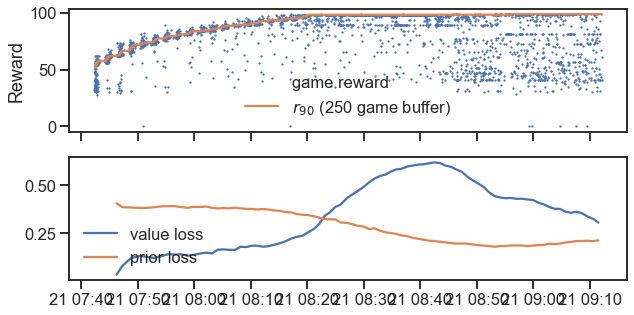

In [60]:
fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(10, 5))

axs[0].plot(df.time, df.real_reward, '.', ms=2.5, label='game reward')
axs[0].plot(df.time, df.real_reward.rolling(250, min_periods=50).quantile(.9), label='$r_{90}$ (250 game buffer)')

axs[1].plot(log.time, log.policy_wrapper_loss, label='value loss')
axs[1].plot(log.time, log.policy_wrapper_1_loss, label='prior loss')

axs[1].legend()
axs[0].legend()

axs[0].set_ylabel('Reward')

In [61]:
# Load the reward buffer to plot the optimal molecules
with psycopg2.connect(**dbparams) as conn:
    rew_df = pd.read_sql_query("select * from {}_reward".format(config.sql_basename), conn)

rew_df.shape

(81118, 7)

In [62]:
rew_df.sort_values('real_reward', ascending=False).head(10)

,smiles,time,real_reward,atom_type,buried_vol,max_spin,atom_index
62962,CN[C@H](CCCN)C([O])=O,2020-10-21 08:17:06.772592,98.690895,C,58.906025,0.204303,2
34901,CN[C](C(C)=O)C(C)(C)C,2020-10-21 07:59:02.477966,98.117720,C,65.035680,0.338359,2
50387,CCC1=C(C)[CH]CC1(C)C,2020-10-21 08:07:13.053034,97.312035,C,66.000305,0.373765,2
44747,CN(C)[C@@H](CCO)C([O])=O,2020-10-21 08:03:37.836768,97.150270,C,61.486156,0.286718,3
41899,[CH2]C1=C(C(C)(C)C)CCC1,2020-10-21 08:02:42.623904,96.993460,C,66.330850,0.386748,2
52771,CC[C@@H](C([O])=O)N(C)CC,2020-10-21 08:08:54.932007,96.888794,N,56.434338,0.190911,6
11401,CC(O)=C(C([O])=O)C(C)C,2020-10-21 07:50:32.705504,96.566600,C,61.795994,0.304588,3
44829,[CH2]C=C(C(C)=O)C(C)(C)C,2020-10-21 08:03:39.704478,96.510994,C,65.045710,0.370694,2
21396,[CH2]C(O)=C(CC)C(C)(C)C,2020-10-21 07:53:11.336992,96.433010,C,67.192110,0.415182,3
52121,[CH2]C=C(CC)C(CC)CC,2020-10-21 08:08:08.856725,96.388360,C,64.736626,0.366965,2


In [63]:
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    orig_costs = np.array(costs)
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return orig_costs[is_efficient_mask]
    else:
        return is_efficient

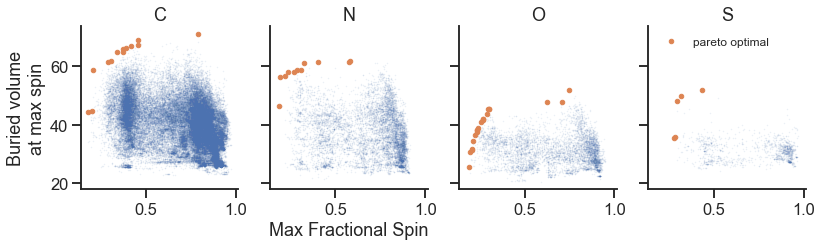

In [64]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(13,3), sharex=True, sharey=True)

optimal = []
for ax, atom in zip(axs, ['C', 'N', 'O', 'S']):
    
    vals = rew_df[rew_df.atom_type == atom][['max_spin', 'buried_vol']].dropna()
    vals['buried_vol'] *= -1
    pareto_index = is_pareto_efficient(vals.values, return_mask=False)
    pareto_points = vals.iloc[pareto_index]
    optimal += [vals.iloc[pareto_index].index]
    
    ax.plot(rew_df[rew_df.atom_type == atom]['max_spin'],
            rew_df[rew_df.atom_type == atom]['buried_vol'], '.', ms=1, alpha=.1)
    
    ax.plot(pareto_points['max_spin'], -pareto_points['buried_vol'], '.', label='pareto optimal')
    
    ax.set_title(atom)

    
axs[1].set_xlabel('Max Fractional Spin')
axs[0].set_ylabel('Buried volume\nat max spin')

axs[-1].legend(loc='upper left', fontsize=12)
sns.despine()    

In [65]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from IPython.display import SVG

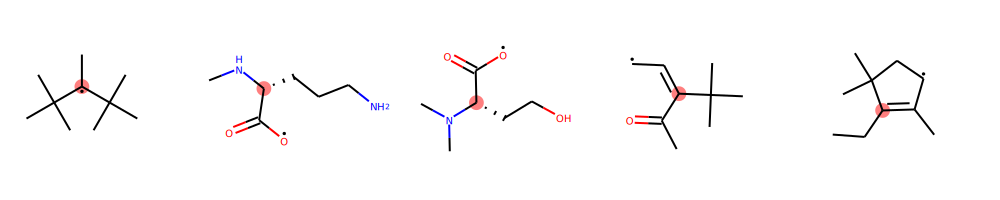

In [66]:
to_plot = rew_df.reindex(pd.Series(optimal[0]).sample(5))
d2d = rdMolDraw2D.MolDraw2DSVG(1000, 200, 200, 200)
opts = d2d.drawOptions()
d2d.DrawMolecules([Chem.MolFromSmiles(row.smiles) for _, row in to_plot.iterrows()],
                  highlightAtoms=[(int(row.atom_index),) for _, row in to_plot.iterrows()])
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

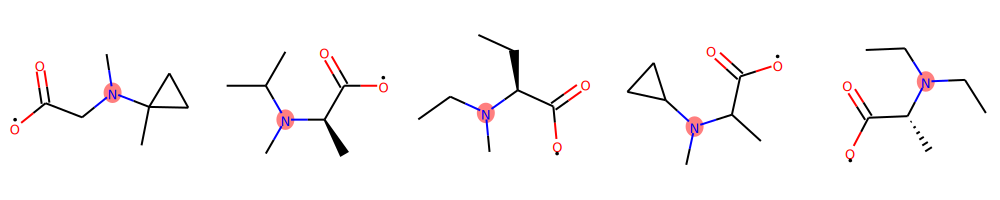

In [72]:
to_plot = rew_df.reindex(pd.Series(optimal[1]).sample(5))
d2d = rdMolDraw2D.MolDraw2DSVG(1000, 200, 200, 200)
opts = d2d.drawOptions()
d2d.DrawMolecules([Chem.MolFromSmiles(row.smiles) for _, row in to_plot.iterrows()],
                  highlightAtoms=[(int(row.atom_index),) for _, row in to_plot.iterrows()])
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

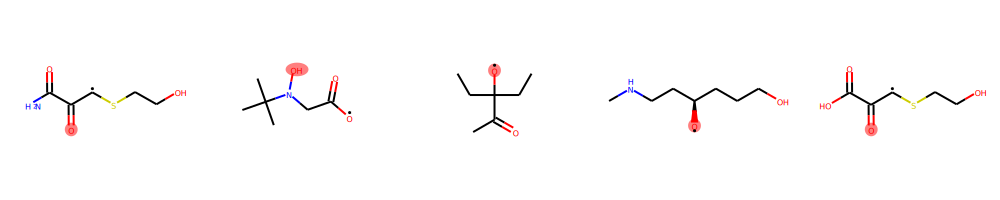

In [87]:
to_plot = rew_df.reindex(pd.Series(optimal[2]))[rew_df.reindex(pd.Series(optimal[2])).buried_vol > 45].sample(5)
d2d = rdMolDraw2D.MolDraw2DSVG(1000, 200, 200, 200)
opts = d2d.drawOptions()
d2d.DrawMolecules([Chem.MolFromSmiles(row.smiles) for _, row in to_plot.iterrows()],
                  highlightAtoms=[(int(row.atom_index),) for _, row in to_plot.iterrows()])
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

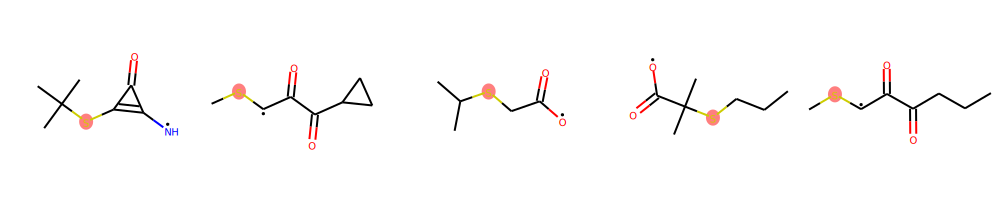

In [69]:
to_plot = rew_df.reindex(pd.Series(optimal[3]).sample(5))
d2d = rdMolDraw2D.MolDraw2DSVG(1000, 200, 200, 200)
opts = d2d.drawOptions()
d2d.DrawMolecules([Chem.MolFromSmiles(row.smiles) for _, row in to_plot.iterrows()],
                  highlightAtoms=[(int(row.atom_index),) for _, row in to_plot.iterrows()])
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

looks like atom ordering isn't consistent

TODO: 
* Maybe do ranked reward on an atom-by-atom basis?

In [ ]:
# rew_df.iloc[optimal[0]]